<a href="https://colab.research.google.com/github/easyhardhoon/machine_learning/blob/master/ML12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

앞서 가중치의 초깃값을 적절히 설정하여 활성화값이 잘 퍼지도록 하여 학습을 원활하게 하였다.

그렇다면 각 층이 활성화를 적당히 퍼트리도록 강제해보면 어떨까

이 알고리즘이 **배치 정규화**이다

#배치 정규화의 아이디어

각 층에서의 활성화값이 적당히 분포되도록 조정한다. 

데이터 분포를 정규화하는 **배치 정규화 계층**을 신경망에 삽입한다

Affine -> batch norm -> Relu(활성화 함수)  이런 식으로!!

단순히 미니배치 입력 데이터들 (원래는 이들 고유의 평균 m, 분산 o가 있을 것이다)을 평균 0, 분산 1인 데이터로 변환(정규화)한다. 

ex) **평균m.분산e 입력 데이터** {x1,x2,....xm} ----> **평균0,분산1 변환 데이터** {x^1,x^2....x^m}

이러한 처리를 활성화 함수의 앞 혹은 뒤에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있다.

또한 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동 변환을 수행한다.

수식 : yi = R* x^i + B ( R : 확대, B : 이동 )

두 값은 처음에는 (1,0) [원본그대로] 이었다가, 학습을 하면서 적합한 값으로 조정해나간다

이 과정이 배치 정규화의 알고리즘이며, 신경망에서 순전파일때 적용된다.

+ 역전파일때는? 다소 복잡하다. 근데..이러면 역전파의 흐름이 최신화되어야 하는거 아닌가..? "배치 정규화"의 layer가 추가되는것 아닌가..?

+ 앞선 layer 계층의 알고리즘대로 구현하면 자연스럽게 "배치 정규화"의 계층도 추가되고 역전파의 알고리즘도 그대로 유지할 수 있을 것 같다....

#배치 정규화의 효과

거의 모든 경우에서 배치 정규화를 사용할 때의 학습 진도가 빠르다.

( 오히려 초깃값의 표준편차가 적절하면 배치 정규화를 안하는게 더 나을떄도 있다)


실제로 배치 정규화를 이용하지 않는 경우엔 초깃값이 잘 분포되지 않으면 학습이 전혀 진행되지 않는 경우도 있다 ( ML11 참고)

#결론

배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 된다. 이러한 부분때문에 다양한 분야에서 활약한다

#오버피팅

오버피팅 : 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 적응하지 못하는 상태

기계학습은 범용 성능을 지향하기 떄문에, 오버피팅을 억제하는 기술이 중요하다

**오버피팅이 발생하는 경우**
+ 매개변수가 많고 표현력이 높은 모델
+ 훈련 데이터가 적음 



In [5]:
#아래 코드는 오버피팅을 일으켜보기 위한 코드입니다. 

In [12]:
# coding: utf-8
import numpy as np
from functions import *
from util import im2col, col2im


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
#from layers import *
from gradient import numerical_gradient


class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

epoch:0, train acc:0.10333333333333333, test acc:0.1087
epoch:1, train acc:0.14666666666666667, test acc:0.1328
epoch:2, train acc:0.19, test acc:0.1591
epoch:3, train acc:0.20666666666666667, test acc:0.1855
epoch:4, train acc:0.27, test acc:0.2146
epoch:5, train acc:0.30666666666666664, test acc:0.2354
epoch:6, train acc:0.34, test acc:0.2605
epoch:7, train acc:0.36, test acc:0.2825
epoch:8, train acc:0.36666666666666664, test acc:0.2909
epoch:9, train acc:0.38666666666666666, test acc:0.3005
epoch:10, train acc:0.39, test acc:0.3098
epoch:11, train acc:0.4166666666666667, test acc:0.33
epoch:12, train acc:0.4533333333333333, test acc:0.3458
epoch:13, train acc:0.4666666666666667, test acc:0.357
epoch:14, train acc:0.4866666666666667, test acc:0.3659
epoch:15, train acc:0.52, test acc:0.3818
epoch:16, train acc:0.5366666666666666, test acc:0.3958
epoch:17, train acc:0.5433333333333333, test acc:0.4088
epoch:18, train acc:0.5633333333333334, test acc:0.4195
epoch:19, train acc:0.57, t

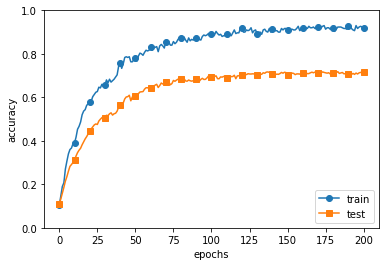

In [11]:
#여기서부터 진짜 코드입니다.
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
#from multi_layer_net import MultiLayerNet
from optimizer import SGD

(x_train,t_train), (x_test,t_test) = load_mnist(normalize=True)

x_train = x_train[:300] #6만개의 데이터 셋중 300개만 사용한 모습입니다
t_train = t_train[:300]

weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list = [100,100,100,100,100,100], \
                        output_size =10, weight_decay_lambda=weight_decay_lambda)
optimizer= SGD(lr=0.01) # 학습률 0.01인 SGD로 매개변수를 갱신하겠습니다.

max_epochs= 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0: # 지금까지의 코드와 같습니다. 에폭마다 모든 훈련데이터와 시험데이터의 정확도를 산출합니다. 
        # 최종적으로 두 데이터에 대한 정확도를 구하기 위한 과정일뿐 입니다.
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs: #일정한 범위를 넘어서면 break 해버립니다.
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#위 코드에서

기본 MNIST의 데이터셋의 훈련 데이터 6만개중 300개만 사용하였고, 7층 네트워크를 사용하여 네트워크의 복잡성을 높였다.

각 층의 뉴런은 100개로 설정하였다. 

즉, MNIST 데이터셋의 훈련데이터를 적게 하였고, 각 층의  뉴런을 100개로 설정함으로써 매개변수가 많은 모델을 선정하였다

위 그래프에서, 훈련 데이터는 100 에폭을 지나는 무렵부터 거의 100프로이지만

시험 데이터와는 점점 큰 차이를 보인다. 이렇게 정확도가 크게 벌어지는 것은 훈련 데이터에만 적응해버린 결과이다.

훈련 떄 사용하지 않는 범용 데이터에 제대로 대응하지 못하는 모습을 볼 수 있다. 즉 오버피팅이 일어남을 볼 수 있다.

#MultiLayerNet 인자의 의미 

TwoLayerNet(input_size, hidden_size, output_size) 에서 각각의 의미는 

입력층 뉴런 수, 은닉층 뉴런 수, 출력층 뉴런 수 이었습니다. 

각각의 층의 뉴런 수는, 가중치 매개변수의 개수라고 생각해도 될 듯 합니다.

그렇다면  MultiLayerNet(input_size, hidden_size_list, output_size) 에서 

단순히 multilayer 이기 떄문에 hidden_size, 즉 각 층마다의 은닉층 뉴런수를 모아둔

hidden_size_list가 필요함을 알 수 있습니다.

즉, **hidden_size_list = [100,100,100,100,100,100] 의 뜻**은, **100개의 뉴런(매개변수)가 있는 은닉층이 6개 있다라는 소리로 해석할 수 있습니다.**

따라서 전체 네트워크는 7층임을 알 수 있습니다. 


#ML13부터는

import를 간단히 구현하여 일일이 복잡한 코드를 복사하는 일이 없도록 하겠습니다.
